In [13]:
import os

import holidays
import pandas as pd
from datetime import datetime

us_holidays = holidays.country_holidays('US', years=[2023])  

# Get the week numbers for each holiday
holiday_weeks = []
for date in us_holidays:
    week_number = datetime.strptime(str(date), "%Y-%m-%d").isocalendar()[1]
    holiday_weeks.append(week_number)
    
holiday_prev_weeks = [1 if week == 52 else week + 1 for week in holiday_weeks]

holiday_prev_weeks = set(holiday_prev_weeks)
print(holiday_prev_weeks)

{1, 2, 4, 37, 9, 42, 46, 48, 23, 26, 28}


In [15]:
import glob
import numpy as np

def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        file_name = os.path.basename(file)
        loc_code = file_name.split('.')[0]  # Split the string at '.' and take the first part
        df['loc_code'] = loc_code
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['date', '1wk_WIS', '1_week_roc', 
                                 'is_wis_above_avg', '1st_deriv_stencil', 
                                 'week_of_year', 'moving_avg_WIS', 
                                 'lagged_1wk_WIS', 'loc_code']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
aggregated_data.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18


In [18]:
"""Add holiday data --- 1 indicates a holiday occurred in the previous week."""
df = aggregated_data.copy()

df['holiday_last_week'] = df['week_of_year'].apply(lambda x: 1 if x in 
                                                              holiday_prev_weeks
else 0)

df.to_csv('./datasets/random_forest_features_20240701.csv', index=False)

In [31]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = aggregated_data
df.dropna(inplace=True)

features = ['1_week_roc', 
            '1st_deriv_stencil', 
            'week_of_year', 
            'moving_avg_WIS', 
            'lagged_1wk_WIS',
            'holiday_last_week']
X = df[features]
y = df['is_wis_above_avg']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       155
           1       0.76      0.70      0.73        69

    accuracy                           0.84       224
   macro avg       0.82      0.80      0.81       224
weighted avg       0.84      0.84      0.84       224



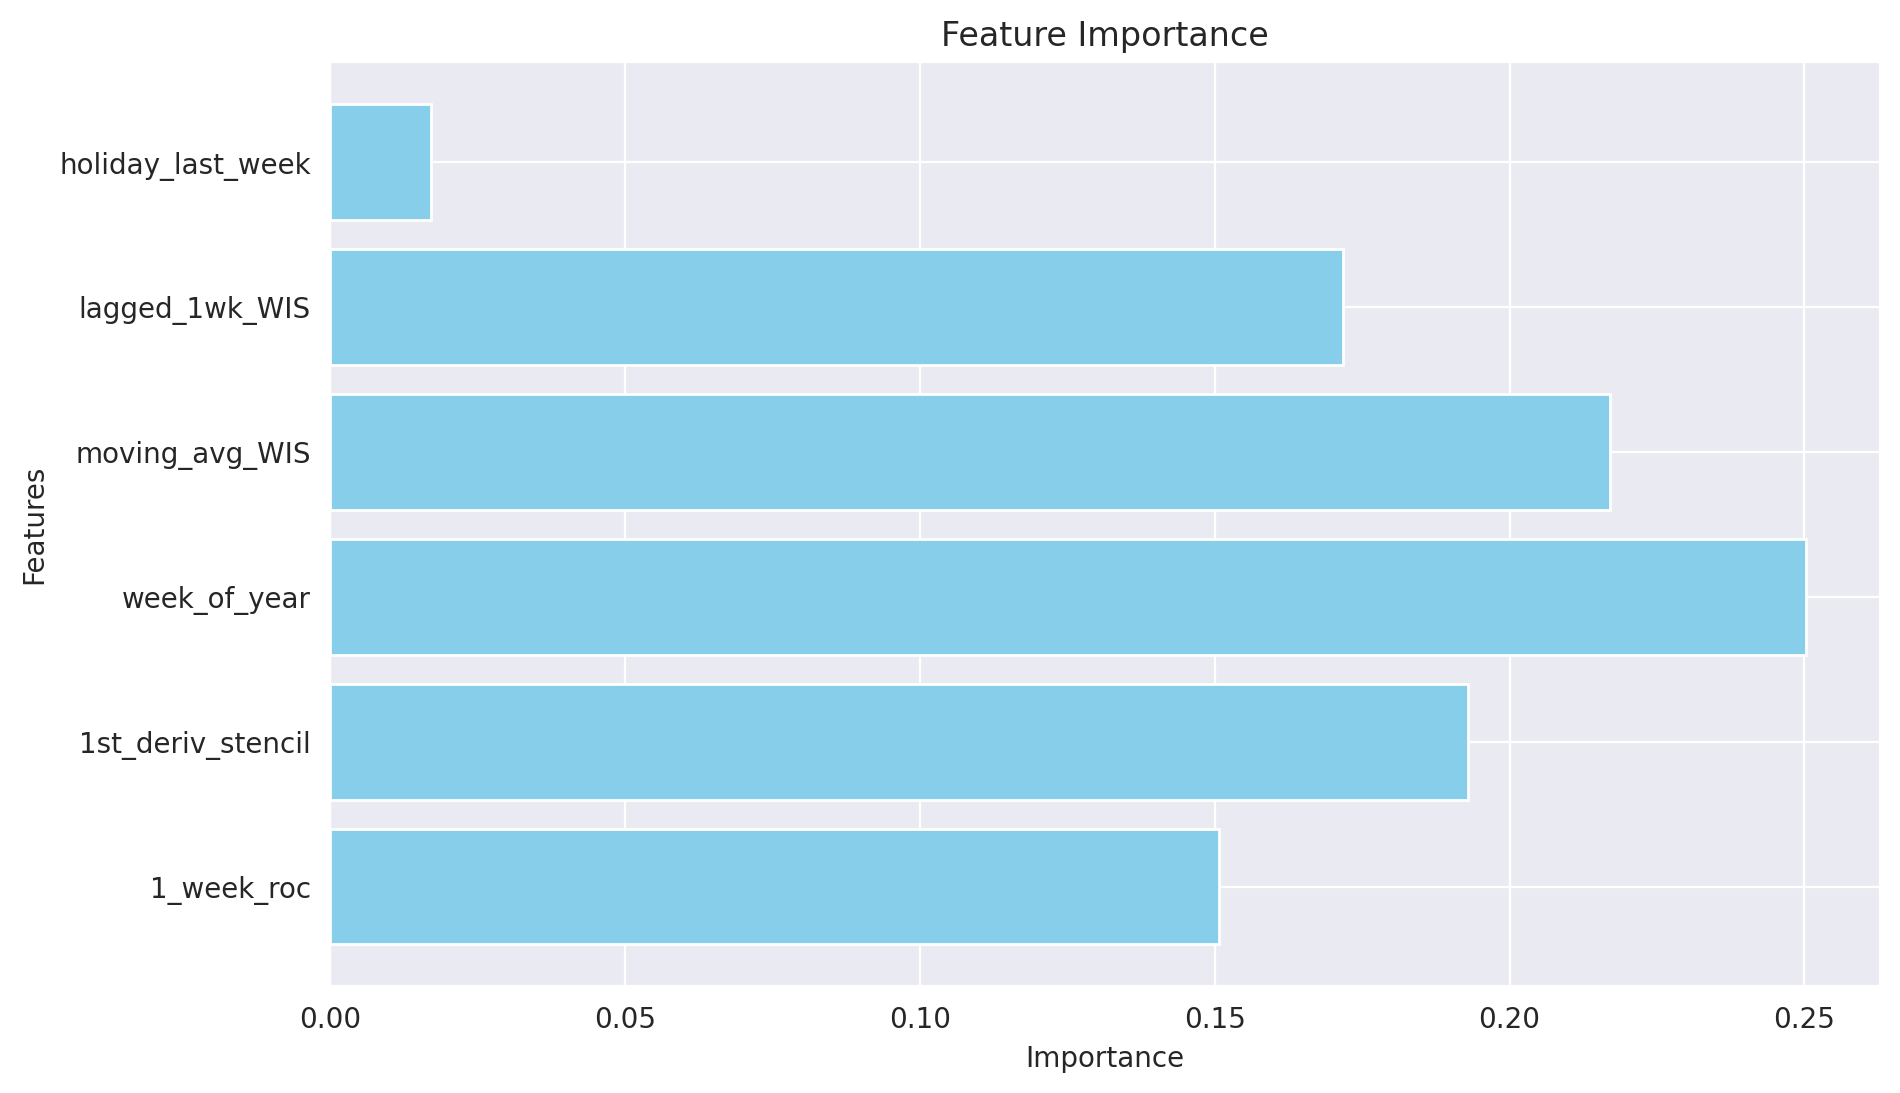

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [34]:
"""Recursive Feature Elimination -- 5 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=5)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS', 'lagged_1wk_WIS',
       'holiday_last_week'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       155
           1       0.75      0.71      0.73        69

    accuracy                           0.84       224
   macro avg       0.81      0.80      0.81       224
weighted avg       0.84      0.84      0.84       224



In [35]:
"""Recursive Feature Elimination -- 4 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=4)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'moving_avg_WIS', 'lagged_1wk_WIS', 'holiday_last_week'], dtype='object')
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       155
           1       0.64      0.62      0.63        69

    accuracy                           0.78       224
   macro avg       0.74      0.73      0.74       224
weighted avg       0.78      0.78      0.78       224



## Changing Features
We are seeing good results (accuracy = 0.84 vs. accuracy = 0.85) after 
eliminating the stencil feature. Let's incorporate another non-ROC feature. 
State-level data? Temperature? Humidity? Movement?  